# Efficient data generation and handling with do-mpc

We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *
import os
import time

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt

import pandas as pd

## Toy example


**Step 1:** Create the ``sampling_plan`` with the ``SamplingPlanner``.

<img src="./figures/sampling_concept_01_planner.pdf" width="60%">


The planner is initiated and we set some (optional) parameters.

In [2]:
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite = True)
# This generates the directory, if it does not exist already.
sp.data_dir = './sampling_test/'

We then introduce new variables to the ``SamplingPlanner`` which will later jointly define a sampling case. Think of header rows in a table (see figure above). 

These variables can themselves be sampled from a generating function or we add user defined cases one by one. If we want to sample variables to define the sampling case, we need to pass a sample generating function as shown below:

In [3]:
sp.set_sampling_var('alpha', np.random.randn)
sp.set_sampling_var('beta', lambda: np.random.randint(0,5))

In this example we have two variables ``alpha`` and ``beta``. We have:

$$
\alpha \sim \mathcal{N}(\mu,\sigma)
$$

and 

$$
\beta\sim \mathcal{U}([0,5])
$$

Having defined generating functions for **all of our variables**, we can now generate a sampling plan with an arbitrary amount of cases:

```python
SamplingPlanner.gen_sampling_plan(n_samples)
```

In [4]:
plan = sp.gen_sampling_plan(n_samples=10)

We can inspect the plan conveniently by converting it to a pandas ``DataFrame``. Natively, the plan is a list of dictionaries.

In [5]:
pd.DataFrame(plan)

,alpha,beta,id
0,3.311025,2,000
1,-0.805400,2,001
2,-0.224488,2,002
3,-1.390615,1,003
4,-0.734131,3,004
5,2.023643,2,005
6,0.055227,4,006
7,0.573169,1,007
8,0.559452,0,008
9,-0.021254,1,009


If we do not wish to automatically generate a sampling plan, we can also add sampling cases one by one with:

In [6]:
plan = sp.add_sampling_case(alpha=1, beta=-0.5)
print(plan[-1])

{'alpha': 1, 'beta': -0.5, 'id': '010'}


Typically, we finish the process of generating the sampling plan by saving it to the disc. This is simply done with:
```python
sp.export(sampling_plan_name)
```
The save directory was already set with ``sp.data_dir = ...``.

**Step 2:** Create the ``Sampler`` object by providing the ``sampling_plan``:

<img src="./figures/sampling_concept_02_sampler.pdf" width="60%">

In [7]:
sampler = do_mpc.sampling.Sampler(plan)
sampler.set_param(overwrite = True)

Most important settting of the sampler is the ``sample_function``. This function takes as arguments previously the defined ``sampling_var`` (from the configuration of the ``SamplingPlanner``).

It this example, we create a dummy sampling generating function, where:

$$
f(\alpha,\beta) = \alpha\cdot\beta
$$

In [8]:
def sample_function(alpha, beta):
    time.sleep(0.1)
    return alpha*beta

sampler.set_sample_function(sample_function)

Before we sample, we want to set the directory for the created files and a name:

In [9]:
sampler.data_dir = './sampling_test/'
sampler.set_param(sample_name = 'dummy_sample')

Now we can actually create all the samples:

In [10]:
sampler.sample_data()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The sampler will now create the sampling results as a new file for each result and store them in a subfolder with the same name as the ``sampling_plan``:

In [11]:
ls = os.listdir('./sampling_test/')
ls.sort()
ls

['dummy_sample_000.pkl',
 'dummy_sample_001.pkl',
 'dummy_sample_002.pkl',
 'dummy_sample_003.pkl',
 'dummy_sample_004.pkl',
 'dummy_sample_005.pkl',
 'dummy_sample_006.pkl',
 'dummy_sample_007.pkl',
 'dummy_sample_008.pkl',
 'dummy_sample_009.pkl',
 'dummy_sample_010.pkl',
 'dummy_sample_011.pkl',
 'dummy_sample_012.pkl']

**Step 3:** Process data in the data handler class. 

<img src="./figures/sampling_concept_03_handler.pdf" width="60%">

The first step is to initiate the class with the ``sampling_plan``:

In [12]:
dh = do_mpc.sampling.DataHandler(plan)

We then need to point out where the data is stored and how the samples are called:

In [13]:
dh.data_dir = './sampling_test/'
dh.set_param(sample_name = 'dummy_sample')

Next, we define the post-processing functions. For this toy example we do some "dummy" post-processing and request to compute two results:

In [14]:
dh.set_post_processing('res_1', lambda x: x)
dh.set_post_processing('res_2', lambda x: x**2)

The interface of ``DataHandler.set_post_processing`` requires a name that we will see again later and a function that processes the output of the previously defined ``sample_function``.

We can now obtain **obtain processed data** from the ``DataHandler`` in two ways. Note that we convert the returned list of dictionaries directly to a ``DataFrame`` for a better visualization.

**1. Indexing**:

In [15]:
pd.DataFrame(dh[:3])

,alpha,beta,id,res_1,res_2
0,3.311025,2,000,6.622050,43.851545
1,-0.805400,2,001,-1.610800,2.594676
2,-0.224488,2,002,-0.448977,0.201580


Or we use a more complex filter with the ``DataHandler.filter`` method. This method requires either an input or an output filter in the form of a function.

Let's retrieve all samples, where $\alpha < 0$:

In [16]:
pd.DataFrame(dh.filter(input_filter = lambda alpha: alpha<0))

,alpha,beta,id,res_1,res_2
0,-0.805400,2,001,-1.610800,2.594676
1,-0.224488,2,002,-0.448977,0.201580
2,-1.390615,1,003,-1.390615,1.933810
3,-0.734131,3,004,-2.202392,4.850532
4,-0.021254,1,009,-0.021254,0.000452


Or we can filter by outputs, e.g. with: 

In [17]:
pd.DataFrame(dh.filter(output_filter = lambda res_2: res_2>10))

,alpha,beta,id,res_1,res_2
0,3.311025,2,000,6.622050,43.851545
1,2.023643,2,005,4.047286,16.380522


# Sampling closed-loop trajectories

A more reasonable use-case in the scope of **do-mpc** is to sample closed-loop trajectories of a dynamical system with a (MPC) controller. 

The approach is almost identical to our toy example above. The main difference lies in the ``sample_function`` that is passed to the ``Sampler`` and the ``post_processing`` in the ``DataHandler``.

In the presented example, we will sample the oscillating mass system which is part of the do-mpc example library. 

In [18]:
sys.path.append('../../../examples/oscillating_masses_discrete/')
from template_model import template_model
from template_mpc import template_mpc
from template_simulator import template_simulator

**Step 1:** Create the ``sampling plan`` with the ``SamplingPlanner``

We want to generate various closed-loop trajectories of the system starting from random initial states, hence we design the ``SamplingPlanner`` as follows:

In [19]:
# Initialize sampling planner
sp = do_mpc.sampling.SamplingPlanner()
sp.set_param(overwrite=True)

# Sample random feasible initial states
def gen_initial_states():
    
    x0 = np.random.uniform(-3*np.ones((4,1)),3*np.ones((4,1)))
    
    return x0

# Add sampling variable including the corresponding evaluation function
sp.set_sampling_var('X0', gen_initial_states)

This implementation is sufficient to generate the sampling plan:

In [20]:
plan = sp.gen_sampling_plan(n_samples=9)

Since we want to run the system in the closed-loop in our sample function, we need to load the corresponding configuration:

In [21]:
model = template_model()
mpc = template_mpc(model)
estimator = do_mpc.estimator.StateFeedback(model)
simulator = template_simulator(model)

We can now define the sampling function:

In [22]:
def run_closed_loop(X0):
    mpc.reset_history()
    simulator.reset_history()
    estimator.reset_history()

    # set initial values and guess
    x0 = X0
    mpc.x0 = x0
    simulator.x0 = x0
    estimator.x0 = x0

    mpc.set_initial_guess()

    # run the closed loop for 150 steps
    for k in range(100):
        u0 = mpc.make_step(x0)
        y_next = simulator.make_step(u0)       
        x0 = estimator.make_step(y_next)

    # we return the complete data structure that we have obtained during the closed-loop run
    return simulator.data

Now we have all the ingredients to make our sampler:

In [23]:
%%capture
# Initialize sampler with generated plan
sampler = do_mpc.sampling.Sampler(plan)
# Set directory to store the results:
sampler.data_dir = './sampling_closed_loop/'
sampler.set_param(overwrite=True)

# Set the sampling function
sampler.set_sample_function(run_closed_loop)

# Generate the data
sampler.sample_data()

**Step 3:** Process data in the data handler class. The first step is to initiate the class with the ``sampling_plan``:

In [24]:
# Initialize DataHandler
dh = do_mpc.sampling.DataHandler(plan)
dh.data_dir = './sampling_closed_loop/'

In this case, we are interested in the states and the inputs of all trajectories. We define the following post processing functions:

In [25]:
dh.set_post_processing('input', lambda data: data['_u', 'u'])
dh.set_post_processing('state', lambda data: data['_x', 'x'])

To retrieve all post-processed data from the datahandler we use slicing. The result is stored in ``res``.

In [26]:
res = dh[:]

To inspect the sampled closed-loop trajectories, we create an array of plots where in each plot $x_2$ is plotted over $x_1$. This shows the different behavior, based on the sampled initial conditions:

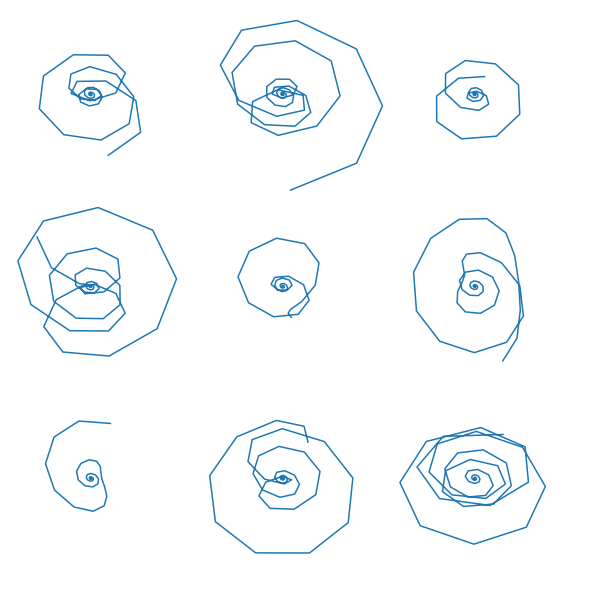

In [27]:
n_res = min(len(res),80)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(res):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['state'][:,1],res_i['state'][:,0])
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
    
fig.tight_layout(pad=0)